<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/plot_sleep_staging_usleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep staging on the Sleep Physionet dataset using U-Sleep network

<div class="alert alert-info"><h4>Note</h4><p>Please take a look at the simpler sleep staging example
    `here <sphx_glr_auto_examples_plot_sleep_staging.py>`
    before going through this example. The current example uses a more complex
    architecture and a sequence-to-sequence (seq2seq) approach.</p></div>

This tutorial shows how to train and test a sleep staging neural network with
Braindecode. We adapt the U-Sleep approach of [1]_ to learn on sequences of EEG
windows using the openly accessible Sleep Physionet dataset [2]_ [3]_.

<div class="alert alert-danger"><h4>Warning</h4><p>The example is written to have a very short execution time.
    This number of epochs is here too small and very few recordings are used.
    To obtain competitive results you need to use more data and more epochs.</p></div>


In [3]:
!pip install braindecode

## Loading and preprocessing the dataset

### Loading

First, we load the data using the
:class:`braindecode.datasets.sleep_physionet.SleepPhysionet` class. We load
two recordings from two different individuals: we will use the first one to
train our network and the second one to evaluate performance (as in the `MNE`_
sleep staging example).





In [4]:
from braindecode.datasets import SleepPhysionet

subject_ids = [0, 1]
crop = (0, 30 * 400)  # we only keep 400 windows of 30s to speed example
dataset = SleepPhysionet(
    subject_ids=subject_ids, recording_ids=[2], crop_wake_mins=30,
    crop=crop)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 23.2GB/s]
100%|█████████████████████████████████████| 4.58k/4.58k [00:00<00:00, 2.65MB/s]
100%|█████████████████████████████████████| 52.0M/52.0M [00:00<00:00, 32.2GB/s]
100%|█████████████████████████████████████| 5.08k/5.08k [00:00<00:00, 2.44MB/s]

Download complete in 01m47s (98.8 MB)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Preprocessing

Next, we preprocess the raw data. We scale each channel recording-wise to
have zero median and unit interquartile range. We don't upsample to 128 Hz as
done in [1]_ so that we keep the example as light as possible. No filtering
is described in [1]_.



In [5]:
from braindecode.preprocessing import preprocess, Preprocessor
from sklearn.preprocessing import robust_scale

preprocessors = [Preprocessor(robust_scale, channel_wise=True)]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 1200000  =      0.000 ... 12000.000 secs...
Reading 0 ... 1200000  =      0.000 ... 12000.000 secs...


### Extract windows

We extract 30-s windows to be used in the classification task.



In [6]:
from braindecode.preprocessing import create_windows_from_events

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4,
}

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload=True,
    mapping=mapping,
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### Split dataset into train and valid

We split the dataset into training and validation set taking
every other subject as train or valid.



In [7]:
split_ids = dict(train=subject_ids[::2], valid=subject_ids[1::2])
splits = windows_dataset.split(split_ids)
train_set, valid_set = splits["train"], splits["valid"]

## Create sequence samplers

Following the sequence-to-sequence approach of [1]_, we need to provide our
neural network with sequences of windows. We can achieve this by defining
Sampler objects that return sequences of windows.
Non-overlapping sequences of 35 windows are used in [1]_, however to limit
the memory requirements for this example we use shorter sequences of 3
windows.



In [8]:
from braindecode.samplers import SequenceSampler

n_windows = 3  # Sequences of 3 consecutive windows; originally 35 in paper
n_windows_stride = 3  # Non-overlapping sequences

train_sampler = SequenceSampler(
    train_set.get_metadata(), n_windows, n_windows_stride, randomize=True
)
valid_sampler = SequenceSampler(valid_set.get_metadata(), n_windows, n_windows_stride)

# Print number of examples per class
print(len(train_sampler))
print(len(valid_sampler))

133
133


Finally, since some sleep stages appear a lot more often than others (e.g.
most of the night is spent in the N2 stage), the classes are imbalanced. To
avoid overfitting to the more frequent classes, we compute weights that we
will provide to the loss function when training.



In [9]:
import numpy as np
from sklearn.utils import compute_class_weight

y_train = [train_set[idx][1][1] for idx in train_sampler]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Create model

We can now create the deep learning model. In this tutorial, we use the
U-Sleep architecture introduced in [1]_, which is fully convolutional
neural network.



In [10]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import USleep

cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=31, cuda=cuda)

n_classes = 5
classes = list(range(n_classes))
# Extract number of channels and time steps from dataset
in_chans, input_size_samples = train_set[0][0].shape
model = USleep(
    n_chans=in_chans,
    sfreq=sfreq,
    depth=12,
    with_skip_connection=True,
    n_outputs=n_classes,
    n_times=input_size_samples
)

# Send model to GPU
if cuda:
    model.cuda()

## Training

We can now train our network. :class:`braindecode.EEGClassifier` is a
braindecode object that is responsible for managing the training of neural
networks. It inherits from :class:`skorch.NeuralNetClassifier`, so the
training logic is the same as in
[Skorch](https://skorch.readthedocs.io/en/stable/)_.

<div class="alert alert-info"><h4>Note</h4><p>We use different hyperparameters from [1]_, as these hyperparameters were
   optimized on different datasets and with a different number of recordings.
   Generally speaking, it is recommended to perform hyperparameter
   optimization if reusing this code on a different dataset or with more
   recordings.</p></div>



In [11]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 32
n_epochs = 3  # we use few epochs for speed and but more than one for plotting

from sklearn.metrics import balanced_accuracy_score


def balanced_accuracy_multi(model, X, y):
    y_pred = model.predict(X)
    return balanced_accuracy_score(y.flatten(), y_pred.flatten())


train_bal_acc = EpochScoring(
    scoring=balanced_accuracy_multi,
    on_train=True,
    name='train_bal_acc',
    lower_is_better=False,
)
valid_bal_acc = EpochScoring(
    scoring=balanced_accuracy_multi,
    on_train=False,
    name='valid_bal_acc',
    lower_is_better=False,
)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    classes=classes,
)
# Deactivate the default valid_acc callback:
clf.set_params(callbacks__valid_acc=None)

# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


  epoch    train_bal_acc    train_loss    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  ---------------  ------------  ------
      1           0.2040        1.6129           0.1707        1.5807  4.4665
      2           0.2224        1.5430           0.1594        1.5866  3.4937
      3           0.3464        1.4928           0.1853        1.6026  3.5452


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  USleep (USleep)                                    [1, 2, 3000]              [1, 5]                    --                        --
  ├─Sequential (encoder): 1-1                        --                        --                        --                        --
  │    └─_EncoderBlock (0): 2-1                      [1, 2, 3000]              [1, 6, 1500]              --                        7
  │    │    └─Sequential (block_prepool): 3-1        [1, 2, 3000]              [1, 6, 3000]              102                       --
  │    │    └─MaxPool1d (maxpool): 3-2               [1, 6, 3000]              [1, 6, 1500]        

## Plot results

We use the history stored by Skorch during training to plot the performance of
the model throughout training. Specifically, we plot the loss and the balanced
balanced accuracy for the training and validation sets.



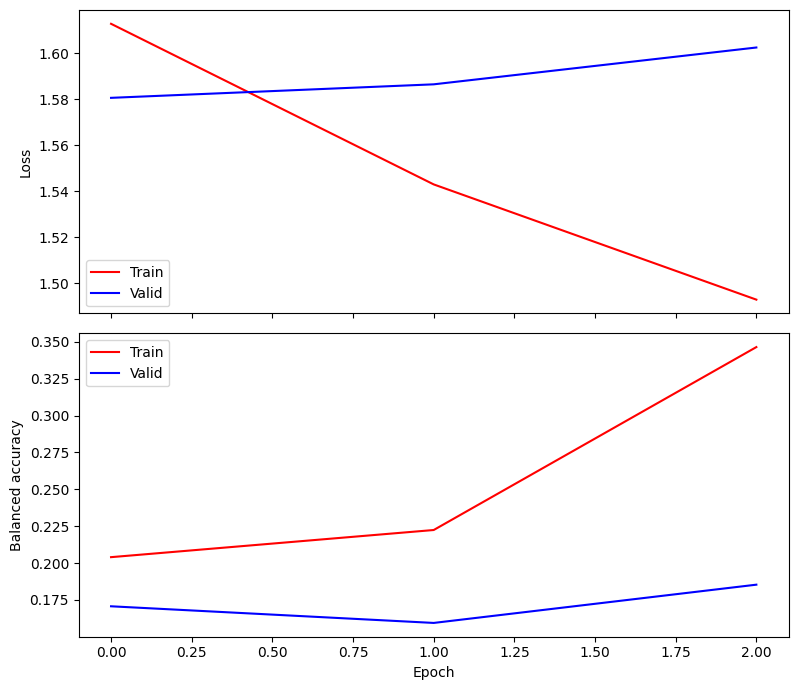

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())
df.index.name = "Epoch"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
df[['train_loss', 'valid_loss']].plot(color=['r', 'b'], ax=ax1)
df[['train_bal_acc', 'valid_bal_acc']].plot(color=['r', 'b'], ax=ax2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Balanced accuracy')
ax1.legend(['Train', 'Valid'])
ax2.legend(['Train', 'Valid'])
fig.tight_layout()
plt.show()

Finally, we also display the confusion matrix and classification report:



              precision    recall  f1-score   support

           0       0.12      0.31      0.17        64
           1       0.03      0.05      0.04        22
           2       0.52      0.34      0.41       197
           3       0.26      0.20      0.23        84
           4       0.25      0.03      0.06        32

    accuracy                           0.26       399
   macro avg       0.24      0.19      0.18       399
weighted avg       0.35      0.26      0.28       399



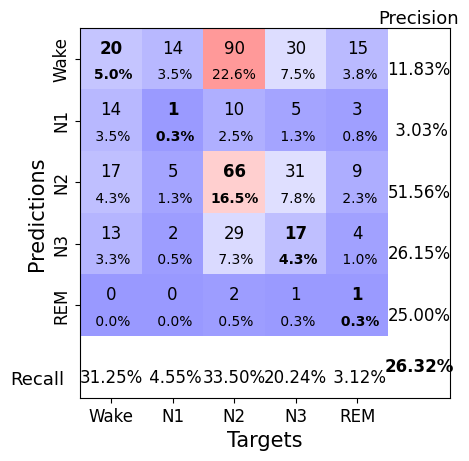

In [13]:
from braindecode.visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

y_true = np.array([valid_set[i][1] for i in valid_sampler])
y_pred = clf.predict(valid_set)

confusion_mat = confusion_matrix(y_true.flatten(), y_pred.flatten())

plot_confusion_matrix(confusion_mat=confusion_mat,
                      class_names=['Wake', 'N1', 'N2', 'N3', 'REM'])

print(classification_report(y_true.flatten(), y_pred.flatten()))

Finally, we can also visualize the hypnogram of the recording we used for
validation, with the predicted sleep stages overlaid on top of the true
sleep stages. We can see that the model cannot correctly identify the
different sleep stages with this amount of training.



Text(0, 0.5, 'Sleep stage')

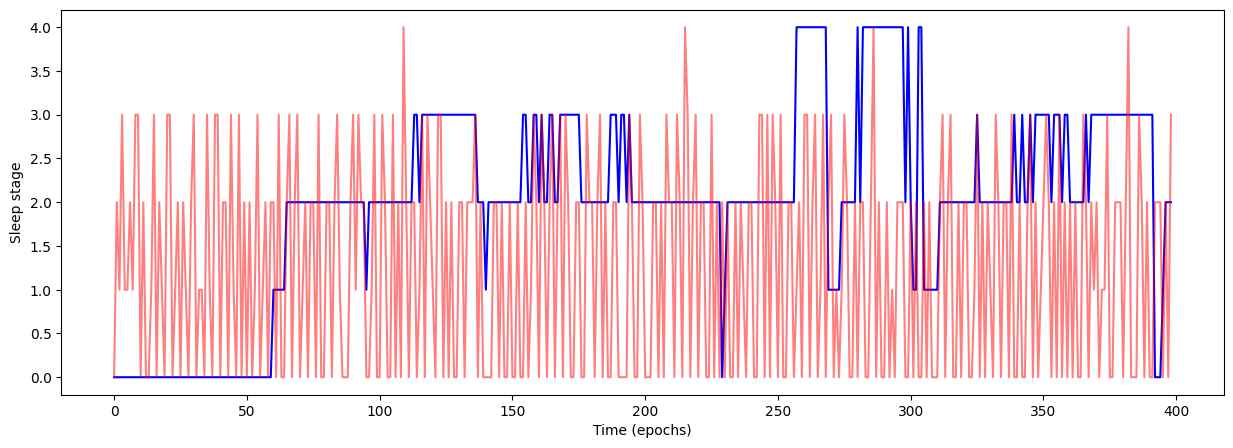

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_true.flatten(), color='b', label='Expert annotations')
ax.plot(y_pred.flatten(), color='r', label='Predict annotations', alpha=0.5)
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Sleep stage')

Our model was able to learn, as shown by the decreasing training and
validation loss values, despite the low amount of data that was available
(only two recordings in this example). To further improve performance, more
recordings should be included in the training set, the model should be
trained for more epochs and hyperparameters should be optimized.

